In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns=100

In [2]:
train=pd.read_csv('train.csv')
holdout=pd.read_csv('test.csv')

In [3]:
#holdout omits 'Survived'
holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [4]:
# %load functions.py
# NOTE - the simple cleaning functions in this cell were coded by DataQuest.  
# The focus of this notebook is practicing the Kaggle workflow.

def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
#process_feat applies cleaning and dummies functions
def process_feat(df, col_list):
    df=process_missing(df)
    df=process_age(df)
    df=process_fare(df)
    df=process_titles(df)
    df=process_cabin(df)
    #applie dummies function several features
    df=create_dummies(df,col_list)
    return df    

In [6]:
train=process_feat(train, ['Age_categories','Fare_categories','Title',\
                          'Cabin_type', 'Sex'])

holdout=process_feat(holdout, ['Age_categories','Fare_categories','Title',\
                          'Cabin_type', 'Sex'])

In [7]:
# Sex - Female/Male columns are redundant

In [8]:
#sibsp - # of siblings / spouses aboard the Titanic
#parch - # of parents / children aboard the Titanic

In [9]:
train.groupby(['SibSp','Survived'])['Survived'].count()

SibSp  Survived
0      0           398
       1           210
1      0            97
       1           112
2      0            15
       1            13
3      0            12
       1             4
4      0            15
       1             3
5      0             5
8      0             7
Name: Survived, dtype: int64

In [10]:
train.groupby(['Parch','Survived'])['Survived'].count()

Parch  Survived
0      0           445
       1           233
1      0            53
       1            65
2      0            40
       1            40
3      0             2
       1             3
4      0             4
5      0             4
       1             1
6      0             1
Name: Survived, dtype: int64

In [11]:
train.pivot_table(index='Parch',values='Survived')

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


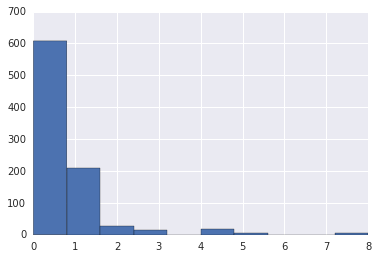

In [12]:
plt.hist(train['SibSp'])
plt.show()

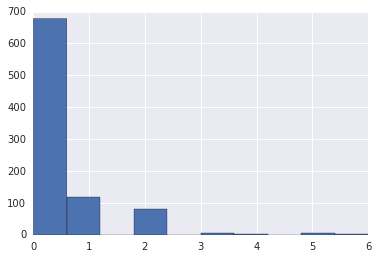

In [13]:
#sns.countplot(train['Parch'])
plt.hist(train['Parch'])
plt.show()

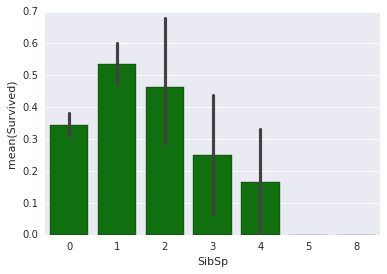

In [14]:
import warnings
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(train['SibSp'], train['Survived'], color='green')
plt.show()

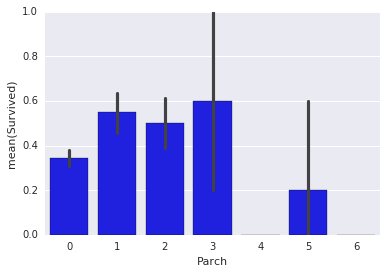

In [15]:
sns.barplot(train['Parch'], train['Survived'], color='blue')
plt.show()

In [16]:
#Engineer feature 'familysize'
train['familysize']=train['SibSp']+train['Parch']
holdout['familysize']=holdout['SibSp']+holdout['Parch']

In [17]:
train.shape

(891, 44)

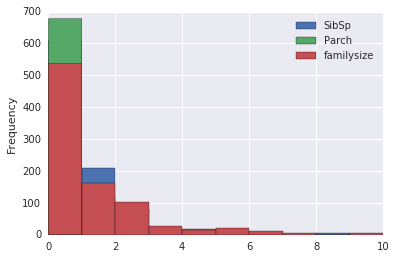

In [18]:
train[['SibSp','Parch','familysize']].plot.hist()
plt.show()

In [19]:
#margins adds grand totals to pivot_table
print('Survivors - 342 total:')
train.pivot_table(index=['familysize'],columns=['Sex'],\
                  values='Survived',aggfunc='sum', margins=True)

Survivors - 342 total:


Sex,female,male,All
familysize,,,
0,99,64,163
1,71,18,89
2,38,21,59
3,16,5,21
4,3,0,3
5,3,0,3
6,3,1,4
7,0,0,0
10,0,0,0


In [20]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

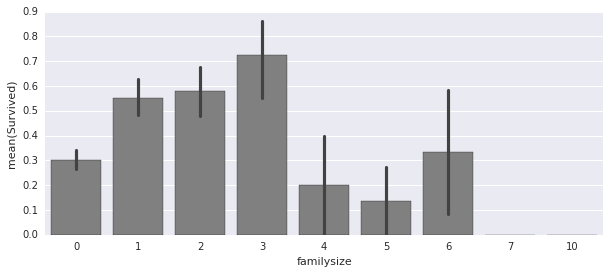

In [21]:
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(train['familysize'], train['Survived'], color='grey')
plt.show()

In [22]:
#Survival rates worse for family size zero and 4+.

In [23]:
def make_isalone(df):
    df['isalone']=0     #create 'isalon'e with 0 = not_alone
    #access df.loc[rows, cols].  Use row mask.
    df.loc[(df['familysize']==0), 'isalone']=1
    return df

In [24]:
train=make_isalone(train)
holdout=make_isalone(holdout)

In [25]:
from IPython.display import display
display(train.head(2))
display(holdout.head(2))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Title,Cabin_type,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,familysize,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult,0-12,Mr,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,50-100,Mrs,C,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Title,Cabin_type,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male,familysize,isalone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Young Adult,0-12,Mr,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Adult,0-12,Mrs,Unknown,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0


In [26]:
#train has Survived and Cabin_type_T.  Not in holdout.

In [27]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [28]:
def select_features(df):    
    #Get numeric df and define all_X and all_y
    num_df=df.select_dtypes(include=['int64','float64','uint8']).copy()
    all_y=num_df['Survived']
    num_df.drop(['PassengerId','Survived'], axis=1, inplace=True)
    all_X=num_df
    
    #Do recursive feature elimination with rfc estimator
    rfc=RandomForestClassifier(random_state=1)
    selector=RFECV(rfc, cv=10)
    selector.fit(all_X, all_y)

    #support_ is the T/F mask of selected features:
    best_feat=all_X.columns[selector.support_]
    #Cabin_type_T removed.  It is almost constant with one instance in df.
    print('best features:', best_feat,'\n')
    return best_feat

In [29]:
best_features=select_features(train)

best features: Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'familysize', 'isalone'],
      dtype='object') 



In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [31]:
def select_model(df, feature_list):
    all_X=df[feature_list].copy()
    all_y=df['Survived'].copy()
    
    #Linear Regression dict ******************************
    lr_dict={
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters":
            {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
    }

    #KNN dict ********************************************
    knn_dict={
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
    }

    #Random Forest dict *********************************
    rfc_dict={
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
            {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
    }

    #create list of dictionaries
    model_list=[lr_dict,knn_dict, rfc_dict]
    
    #
    for d in model_list:
        print('#### ', d['name'], ' ####')
        grid=GridSearchCV(estimator=d['estimator'],\
                          param_grid=d['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        d['best_params']=grid.best_params_
        d['best_score']=grid.best_score_        
        print(d['name'],'best params:', grid.best_params_)
        print(d['name'],'best score:', grid.best_score_,'\n')
    d['best_model']=grid.best_estimator_
    print('## best estimator: ##', grid.best_estimator_)
    return model_list

In [32]:
model_results=select_model(train, best_features)

####  LogisticRegression  ####
LogisticRegression best params: {'solver': 'newton-cg'}
LogisticRegression best score: 0.8181818181818182 

####  KNeighborsClassifier  ####
KNeighborsClassifier best params: {'weights': 'uniform', 'p': 1, 'n_neighbors': 3, 'algorithm': 'kd_tree'}
KNeighborsClassifier best score: 0.7800224466891134 

####  RandomForestClassifier  ####
RandomForestClassifier best params: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
RandomForestClassifier best score: 0.8417508417508418 

## best estimator: ## RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [38]:
def save_submission_file(model, best_feat, filename='submission.csv'):
    holdout_data=holdout[best_features]
    predictions=model.predict(holdout_data)
    submission = pd.DataFrame({"PassengerId": holdout['PassengerId'],\
                               "Survived": predictions})
    submission.to_csv(filename, index=False)
                         
best_mod=model_results[2]['best_model']                            
save_submission_file(best_mod, best_features)                     